# **IT-890 Practical/Professional Seminar Course Project :** **"Urban Sound Classification"**
### ***Contributed By:-***
Tarushi Jat (202IT029)

### **Notebook III: Training CNN & VGG16 Model**

****

## **1. Libraries**

In [ ]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import random
from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

## **2. Urban Sound Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
audio_path = '/content/drive/MyDrive/Projects/UrbanSound'
metadata_path = '/content/drive/MyDrive/Projects/UrbanSound8K.csv'

In [ ]:
metadata = pd.read_csv(metadata_path)
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


## **3. Methods for Performance Metrics Measures & Graph Plotting**

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    return train_score, test_score

In [ ]:
def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
    dash = '-' * 38
    train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)
    
    print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
    print(dash)
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))
    if (calc_normal):
        max_err = max(train_score[0], test_score[0])
        error_diff = max_err - min(train_score[0], test_score[0])
        normal_diff = error_diff * 100 / max_err
        print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))

In [ ]:
def acc_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['accuracy'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_accuracy'],color='#641E16',marker='h')
  plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def loss_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['loss'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_loss'],color='#641E16',marker='h')
  plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def acc_per_class(np_probs_array):    
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = np_probs_array[idx][idx].astype(int)
        total = np_probs_array[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

## **4. Loading Extracted MFCCs**

In [ ]:
X = np.load("/content/drive/MyDrive/Projects/UrbanSound/X-mfcc.npy")
y = np.load("/content/drive/MyDrive/Projects/UrbanSound/y-mfcc.npy")

## **5. Train and Test Splitting**

In [ ]:
indexes = []
total = 8262 #Some files was corrupted...so I just ignored them.
indexes = list(range(0, total))
random.shuffle(indexes) #Randomizing Indexes

In [ ]:
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

In [ ]:
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

In [ ]:
#Spliting the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

In [ ]:
#Also spliting metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

In [ ]:
print("--------------------Test Data Details--------------------")
print("Test split: {} ".format(len(test_meta)))
print("X test shape: {} ".format(X_test.shape))
print("y test shape: {} ".format(y_test.shape))
print("--------------------Train Data Details--------------------")
print("Train split: {}".format(len(train_meta)))
print("X train shape: {}".format(X_train.shape))
print("y train shape: {}".format(y_train.shape))

--------------------Test Data Details--------------------
Test split: 1652 
X test shape: (1652, 40, 174) 
y test shape: (1652,) 
--------------------Train Data Details--------------------
Train split: 6610
X train shape: (6610, 40, 174)
y train shape: (6610,)


## **6. Normalizing the Data**

In [ ]:
num_rows = 40
num_columns = 174
num_channels = 1

In [ ]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [ ]:
# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

In [ ]:
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

## **7. CNN Model Architecture - 1**

In [ ]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate), input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))

    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))

    
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_labels, activation='softmax'))
    return model

In [ ]:
#Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005
#Calling Model
model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 83, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 83, 64)        0

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [ ]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=25, verbose=1, mode='auto')

In [ ]:
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=250, validation_split=1/12., verbose=1, callbacks=[early])

Epoch 1/250
48/48 [==============================] - 38s 84ms/step - loss: 2.3670 - accuracy: 0.1098 - val_loss: 2.3390 - val_accuracy: 0.1234
Epoch 2/250
48/48 [==============================] - 3s 55ms/step - loss: 2.3325 - accuracy: 0.1187 - val_loss: 2.2891 - val_accuracy: 0.1234
Epoch 3/250
48/48 [==============================] - 3s 54ms/step - loss: 2.2938 - accuracy: 0.1171 - val_loss: 2.2523 - val_accuracy: 0.1234
Epoch 4/250
48/48 [==============================] - 3s 54ms/step - loss: 2.2542 - accuracy: 0.1209 - val_loss: 2.2167 - val_accuracy: 0.1125
Epoch 5/250
48/48 [==============================] - 3s 55ms/step - loss: 2.2247 - accuracy: 0.1159 - val_loss: 2.1868 - val_accuracy: 0.1379
Epoch 6/250
48/48 [==============================] - 3s 55ms/step - loss: 2.1998 - accuracy: 0.1441 - val_loss: 2.1503 - val_accuracy: 0.2087
Epoch 7/250
48/48 [==============================] - 3s 55ms/step - loss: 2.1824 - accuracy: 0.1821 - val_loss: 2.1168 - val_accuracy: 0.2250
Epoch

## **8. Evaluating model through different performance metrics**

In [ ]:
labels = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

### **8.1 Accuracy**

In [ ]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         1.0234       69.2284
Test:             1.0232       67.4939


### **8.2 Visualizing Accuracy in Each Epoch**

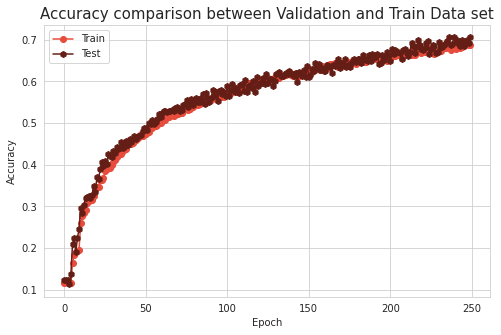

In [ ]:
acc_plot(history)

### **8.3 Visualizing Loss in Each Epoch**

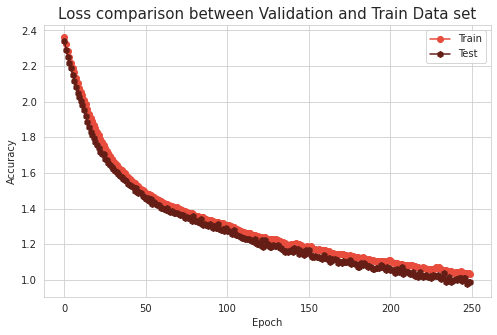

In [ ]:
loss_plot(history)

### **8.4 Confusion Matrix**

In [ ]:
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) #Getting predicted labels
y_trues = np.argmax(y_test_encoded, axis=1)

In [ ]:
cm = confusion_matrix(y_trues, yhat_probs)
cm

array([[123,   0,   5,   4,   3,  16,   0,  12,   5,  25],
       [  0,  51,   3,   4,   5,   0,   5,   2,   0,   7],
       [ 13,   1,  91,  20,   1,  10,   0,   5,   4,  34],
       [  4,   4,  20, 124,   3,   1,  20,   1,   7,   5],
       [ 11,   5,   6,  18, 117,   6,   4,  12,   3,   6],
       [ 24,   0,  11,   2,   2, 145,   1,   1,   3,   2],
       [  0,   0,   0,   0,   0,   0,  70,   1,   0,   0],
       [ 22,   1,   6,   3,  23,   7,   5, 136,   0,   6],
       [  1,   5,   6,   6,   2,   1,   0,   0, 146,   3],
       [ 18,   4,  21,   6,   8,   2,   0,   2,  12, 112]])

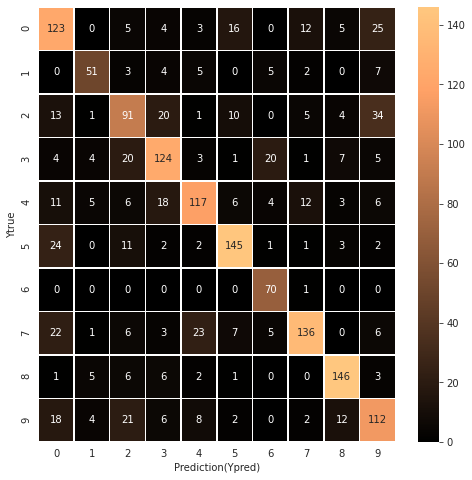

In [ ]:
def display_cm():
  CM = confusion_matrix(y_trues, yhat_probs)
  f, ax = plt.subplots(figsize=(8,8))
  sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()
display_cm()

### **8.5 Classification Report**

In [ ]:
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.57      0.64      0.60       193
        Car Horn       0.72      0.66      0.69        77
Children Playing       0.54      0.51      0.52       179
        Dog bark       0.66      0.66      0.66       189
        Drilling       0.71      0.62      0.66       188
   Engine Idling       0.77      0.76      0.77       191
        Gun Shot       0.67      0.99      0.80        71
      Jackhammer       0.79      0.65      0.71       209
           Siren       0.81      0.86      0.83       170
    Street Music       0.56      0.61      0.58       185

        accuracy                           0.67      1652
       macro avg       0.68      0.69      0.68      1652
    weighted avg       0.68      0.67      0.67      1652



### **8.6 Accuracy per Class**

In [ ]:
accuracies = acc_per_class(cm)
pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,98.591549
8,Siren,85.882353
5,Engine Idling,75.916230
1,Car Horn,66.233766
3,Dog bark,65.608466
7,Jackhammer,65.071770
0,Air Conditioner,63.730570
4,Drilling,62.234043
9,Street Music,60.540541
2,Children Playing,50.837989


## **9. CNN Model Architecture - Performance Tuning**

In [ ]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate), input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_labels, activation='softmax'))
    return model

In [ ]:
#Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005
#Calling Model
model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 172, 32)       128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 85, 32)       

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [ ]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=25, verbose=1, mode='auto')

In [ ]:
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=250, validation_split=1/12., verbose=1, callbacks=[early])

Epoch 1/250
48/48 [==============================] - 5s 82ms/step - loss: 2.2763 - accuracy: 0.1761 - val_loss: 2.3962 - val_accuracy: 0.1107
Epoch 2/250
48/48 [==============================] - 4s 76ms/step - loss: 1.9582 - accuracy: 0.3392 - val_loss: 2.4498 - val_accuracy: 0.1107
Epoch 3/250
48/48 [==============================] - 4s 76ms/step - loss: 1.8406 - accuracy: 0.3871 - val_loss: 2.5597 - val_accuracy: 0.0436
Epoch 4/250
48/48 [==============================] - 4s 77ms/step - loss: 1.7363 - accuracy: 0.4373 - val_loss: 2.8221 - val_accuracy: 0.0799
Epoch 5/250
48/48 [==============================] - 4s 77ms/step - loss: 1.6832 - accuracy: 0.4483 - val_loss: 3.1943 - val_accuracy: 0.0635
Epoch 6/250
48/48 [==============================] - 4s 77ms/step - loss: 1.6375 - accuracy: 0.4648 - val_loss: 3.4525 - val_accuracy: 0.0617
Epoch 7/250
48/48 [==============================] - 4s 77ms/step - loss: 1.6065 - accuracy: 0.4846 - val_loss: 3.4977 - val_accuracy: 0.0599
Epoch 

## **10. Evaluating model through different performance metrics**

In [ ]:
labels = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

### **10.1 Accuracy**

In [ ]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.3767       91.6188
Test:             0.4449       88.4383


### **10.2 Visualizing Accuracy in Each Epoch**

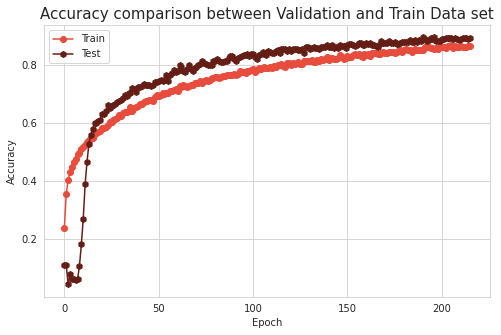

In [ ]:
acc_plot(history)

### **10.3 Visualizing Loss in Each Epoch**

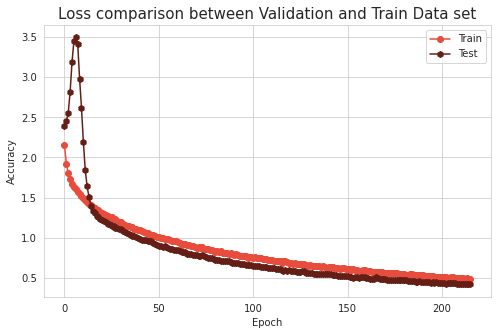

In [ ]:
loss_plot(history)

### **10.4 Confusion Matrix**

In [ ]:
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) #Getting predicted labels
y_trues = np.argmax(y_test_encoded, axis=1)

In [ ]:
cm = confusion_matrix(y_trues, yhat_probs)
cm

array([[181,   0,   3,   0,   0,   0,   0,   3,   0,   6],
       [  2,  71,   0,   1,   1,   0,   0,   2,   0,   0],
       [  5,   0, 142,  10,   1,   2,   1,   0,   1,  17],
       [  6,   3,  11, 155,   4,   1,   2,   0,   3,   4],
       [  1,   5,   2,   9, 156,   1,   4,   7,   3,   0],
       [  9,   0,   3,   3,   0, 175,   0,   0,   1,   0],
       [  0,   0,   0,   0,   1,   0,  70,   0,   0,   0],
       [  2,   3,   0,   0,   2,   0,   1, 201,   0,   0],
       [  0,   0,   4,   3,   0,   2,   0,   0, 159,   2],
       [ 11,   0,  11,   2,   3,   1,   0,   1,   5, 151]])

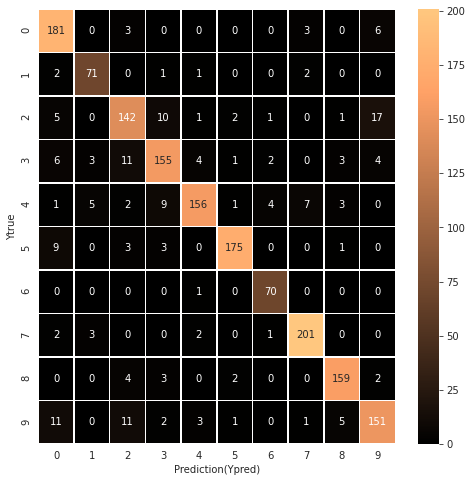

In [ ]:
def display_cm():
  CM = confusion_matrix(y_trues, yhat_probs)
  f, ax = plt.subplots(figsize=(8,8))
  sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()
display_cm()

### **10.5 Classification Report**

In [ ]:
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.83      0.94      0.88       193
        Car Horn       0.87      0.92      0.89        77
Children Playing       0.81      0.79      0.80       179
        Dog bark       0.85      0.82      0.83       189
        Drilling       0.93      0.83      0.88       188
   Engine Idling       0.96      0.92      0.94       191
        Gun Shot       0.90      0.99      0.94        71
      Jackhammer       0.94      0.96      0.95       209
           Siren       0.92      0.94      0.93       170
    Street Music       0.84      0.82      0.83       185

        accuracy                           0.88      1652
       macro avg       0.88      0.89      0.89      1652
    weighted avg       0.89      0.88      0.88      1652



### **10.6 Accuracy per Class**

In [ ]:
accuracies = acc_per_class(cm)
pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,98.591549
7,Jackhammer,96.172249
0,Air Conditioner,93.782383
8,Siren,93.529412
1,Car Horn,92.207792
5,Engine Idling,91.623037
4,Drilling,82.978723
3,Dog bark,82.010582
9,Street Music,81.621622
2,Children Playing,79.329609


## **11. CNN Model Architecture - Performance Tuning**

In [ ]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate), input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_labels, activation='softmax'))
    return model

In [ ]:
#Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005
#Calling Model
model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 36, 170, 32)      

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [ ]:
from keras.callbacks import EarlyStopping
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=25, verbose=1, mode='auto')

In [ ]:
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=250, validation_split=1/12., verbose=1, callbacks=[early])

Epoch 1/250
48/48 [==============================] - 4s 73ms/step - loss: 2.1784 - accuracy: 0.2486 - val_loss: 2.3812 - val_accuracy: 0.1216
Epoch 2/250
48/48 [==============================] - 3s 67ms/step - loss: 1.7764 - accuracy: 0.3956 - val_loss: 2.4207 - val_accuracy: 0.1760
Epoch 3/250
48/48 [==============================] - 3s 67ms/step - loss: 1.6389 - accuracy: 0.4404 - val_loss: 2.5232 - val_accuracy: 0.1996
Epoch 4/250
48/48 [==============================] - 3s 67ms/step - loss: 1.5342 - accuracy: 0.5023 - val_loss: 2.7142 - val_accuracy: 0.1234
Epoch 5/250
48/48 [==============================] - 3s 67ms/step - loss: 1.4615 - accuracy: 0.5449 - val_loss: 2.8564 - val_accuracy: 0.1234
Epoch 6/250
48/48 [==============================] - 3s 68ms/step - loss: 1.4141 - accuracy: 0.5604 - val_loss: 2.9144 - val_accuracy: 0.1561
Epoch 7/250
48/48 [==============================] - 3s 68ms/step - loss: 1.3621 - accuracy: 0.5917 - val_loss: 2.9330 - val_accuracy: 0.1289
Epoch 

## **12. Evaluating model through different performance metrics**

In [ ]:
labels = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

### **12.1 Accuracy**

In [ ]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.2244       95.8094
Test:             0.3661       90.9806


### **12.2 Visualizing Accuracy in Each Epoch**

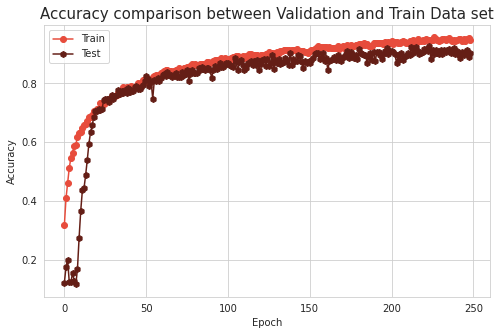

In [ ]:
acc_plot(history)

### **12.3 Visualizing Loss in Each Epoch**

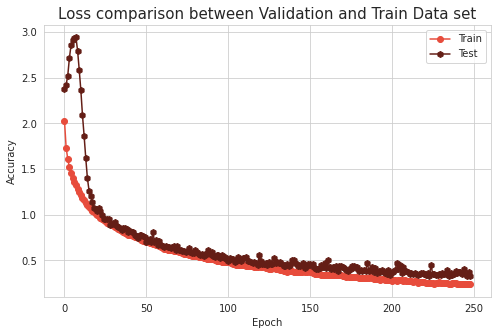

In [ ]:
loss_plot(history)

### **12.4 Confusion Matrix**

In [ ]:
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) #Getting predicted labels
y_trues = np.argmax(y_test_encoded, axis=1)

In [ ]:
cm = confusion_matrix(y_trues, yhat_probs)
cm

array([[184,   0,   0,   1,   0,   3,   0,   1,   0,   4],
       [  1,  71,   0,   1,   2,   0,   0,   0,   0,   2],
       [  1,   1, 153,   5,   0,   3,   1,   0,   1,  14],
       [  2,   6,   9, 160,   1,   3,   0,   0,   7,   1],
       [  0,   4,   3,   7, 167,   1,   0,   6,   0,   0],
       [  0,   1,   2,   0,   0, 185,   0,   0,   2,   1],
       [  0,   0,   0,   4,   1,   0,  66,   0,   0,   0],
       [  1,   4,   0,   0,   4,   1,   0, 197,   1,   1],
       [  0,   0,   1,   1,   0,   1,   0,   0, 165,   2],
       [  4,   0,  16,   2,   0,   3,   0,   0,   5, 155]])

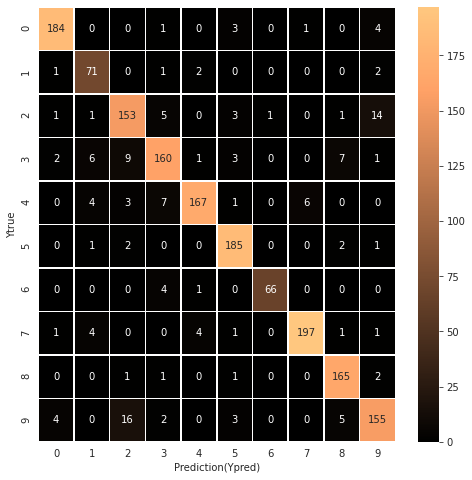

In [ ]:
def display_cm():
  CM = confusion_matrix(y_trues, yhat_probs)
  f, ax = plt.subplots(figsize=(8,8))
  sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()
display_cm()

### **12.5 Classification Report**

In [ ]:
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.95      0.95      0.95       193
        Car Horn       0.82      0.92      0.87        77
Children Playing       0.83      0.85      0.84       179
        Dog bark       0.88      0.85      0.86       189
        Drilling       0.95      0.89      0.92       188
   Engine Idling       0.93      0.97      0.95       191
        Gun Shot       0.99      0.93      0.96        71
      Jackhammer       0.97      0.94      0.95       209
           Siren       0.91      0.97      0.94       170
    Street Music       0.86      0.84      0.85       185

        accuracy                           0.91      1652
       macro avg       0.91      0.91      0.91      1652
    weighted avg       0.91      0.91      0.91      1652



### **12.6 Accuracy per Class**

In [ ]:
accuracies = acc_per_class(cm)
pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
8,Siren,97.058824
5,Engine Idling,96.858639
0,Air Conditioner,95.336788
7,Jackhammer,94.258373
6,Gun Shot,92.957746
1,Car Horn,92.207792
4,Drilling,88.829787
2,Children Playing,85.474860
3,Dog bark,84.656085
9,Street Music,83.783784


## **VGG 16 Architecture**

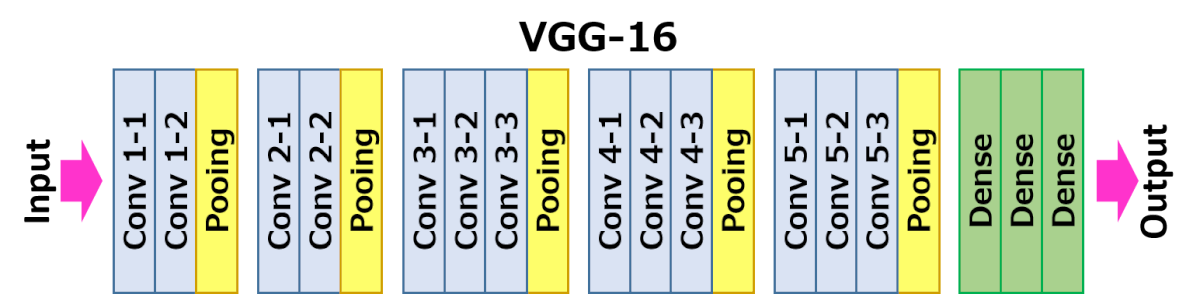

In [ ]:
model = Sequential()
model.add(Conv2D(input_shape=(40,174,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=10, activation="softmax"))  

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 40, 174, 64)       640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 40, 174, 64)       36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 20, 87, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 87, 128)       73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 20, 87, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 10, 43, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 43, 256)      

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [ ]:
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=250, validation_split=1/12., verbose=1)

Epoch 1/250
48/48 [==============================] - 60s 420ms/step - loss: 2.2684 - accuracy: 0.1223 - val_loss: 2.1613 - val_accuracy: 0.1270
Epoch 2/250
48/48 [==============================] - 14s 295ms/step - loss: 2.0797 - accuracy: 0.1994 - val_loss: 1.9337 - val_accuracy: 0.3013
Epoch 3/250
48/48 [==============================] - 14s 298ms/step - loss: 1.8799 - accuracy: 0.2635 - val_loss: 1.7796 - val_accuracy: 0.2995
Epoch 4/250
48/48 [==============================] - 14s 293ms/step - loss: 1.6914 - accuracy: 0.3317 - val_loss: 1.6695 - val_accuracy: 0.3848
Epoch 5/250
48/48 [==============================] - 14s 290ms/step - loss: 1.5546 - accuracy: 0.4105 - val_loss: 1.5904 - val_accuracy: 0.3975
Epoch 6/250
48/48 [==============================] - 14s 290ms/step - loss: 1.4635 - accuracy: 0.4477 - val_loss: 1.4592 - val_accuracy: 0.4428
Epoch 7/250
48/48 [==============================] - 14s 290ms/step - loss: 1.3528 - accuracy: 0.4850 - val_loss: 1.3655 - val_accuracy:

## **Evaluating model through different performance metrics**

In [ ]:
labels = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

### **Accuracy**

In [ ]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.0956       98.3812
Test:             0.7636       91.2833


### **Visualizing Accuracy in Each Epoch**

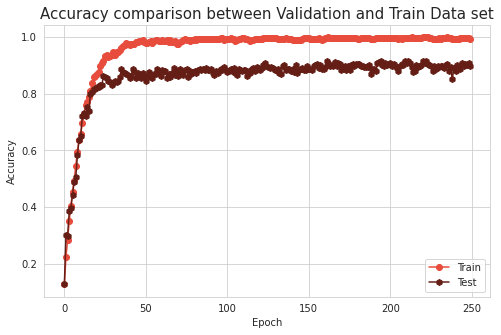

In [ ]:
acc_plot(history)

### **Visualizing Loss in Each Epoch**

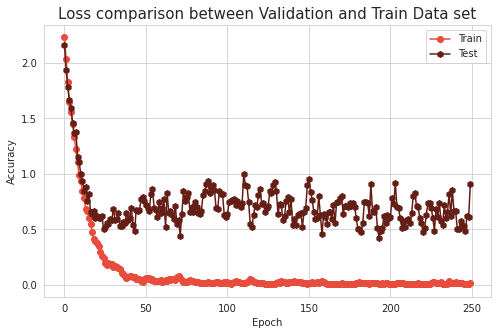

In [ ]:
loss_plot(history)

### **Confusion Matrix**

In [ ]:
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) #Getting predicted labels
y_trues = np.argmax(y_test_encoded, axis=1)

In [ ]:
cm = confusion_matrix(y_trues, yhat_probs)
cm

array([[170,   0,   4,   0,   0,   5,   0,   0,   3,   7],
       [  0,  76,   2,   5,   0,   1,   1,   0,   0,   1],
       [  0,   0, 171,   5,   0,   3,   0,   0,   3,   6],
       [  0,   0,  12, 183,   4,   0,   0,   0,   7,   0],
       [  0,   1,   3,   7, 164,   0,   5,   8,   0,   0],
       [  1,   0,   5,   0,   0, 177,   0,   0,   3,   0],
       [  0,   0,   6,   0,   1,   0,  77,   0,   0,   0],
       [  1,   0,   0,   0,   8,   0,   0, 173,   1,   0],
       [  0,   1,   2,   1,   0,  22,   0,   0, 131,   0],
       [  0,   1,  19,   1,   0,   0,   0,   1,   3, 160]])

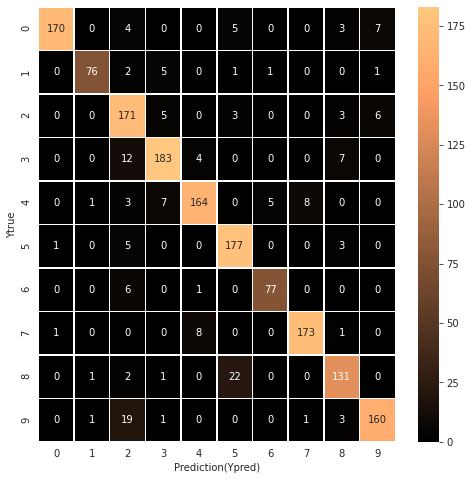

In [ ]:
def display_cm():
  CM = confusion_matrix(y_trues, yhat_probs)
  f, ax = plt.subplots(figsize=(8,8))
  sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.copper)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()
display_cm()

### **Classification Report**

In [ ]:
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.99      0.90      0.94       189
        Car Horn       0.96      0.88      0.92        86
Children Playing       0.76      0.91      0.83       188
        Dog bark       0.91      0.89      0.90       206
        Drilling       0.93      0.87      0.90       188
   Engine Idling       0.85      0.95      0.90       186
        Gun Shot       0.93      0.92      0.92        84
      Jackhammer       0.95      0.95      0.95       183
           Siren       0.87      0.83      0.85       157
    Street Music       0.92      0.86      0.89       185

        accuracy                           0.90      1652
       macro avg       0.91      0.90      0.90      1652
    weighted avg       0.90      0.90      0.90      1652



### **Accuracy per Class**

In [ ]:
accuracies = acc_per_class(cm)
pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
5,Engine Idling,95.161290
7,Jackhammer,94.535519
6,Gun Shot,91.666667
2,Children Playing,90.957447
0,Air Conditioner,89.947090
3,Dog bark,88.834951
1,Car Horn,88.372093
4,Drilling,87.234043
9,Street Music,86.486486
8,Siren,83.439490


**Done :]**